# Underway quick look at files

Load the data and make some plots and stuff using `kval`'s built-in functionality (basic stuff for now).

In [172]:
# Load the ctd module from the kval library  
from kval.data import ctd
import glob2

# for data manipualtion
import pandas as pd
import xarray as xr
import numpy as np
import gsw
from sklearn.linear_model import LinearRegression

# for custom plotting
import matplotlib.pyplot as plt
# Set the matplotlib backend so we can interact with the plots (zoom, click buttons etc)
%matplotlib widget

## Load data from `.cnv`s

In [173]:
# Get a list of the processed CTD-data files
cnv_list_all = glob2.glob('../../../../proc/*.cnv')

# Get lists of binne and unbinned data, respectively
cnv_list_bin = [file for file in cnv_list_all if '_bin' in file]
cnv_list_nbin = [file for file in cnv_list_all if not  '_bin' in file]

In [174]:
# Load the CTD data as joined xarray dataset
# ds = ctd.ctds_from_cnv_dir('../../../../proc/')
ds_ctd = ctd.ctds_from_cnv_list(cnv_list_bin, station_from_filename=False)

# manually fix station name (string entered when starting the data recording, should have been statio number only)
ds_ctd.STATION[0] = 60
ds_ctd.STATION[1] = 72
ds_ctd.STATION[2] = 74
ds_ctd.STATION[3] = 83
ds_ctd.STATION[4] = '85'

NOTE!: 72: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: 74: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: stnr0083: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: stnr0084: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: 95: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: 106: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: 113: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: 118: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: 127: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: 132: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: 133: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: * Station:: Unable

Joining profiles together:   0%|          | 0/12 [00:00<?, ?it/s]

In [175]:
# WHY Station 60 included? Mistake or to ease plotting?

In [176]:
print(ds_ctd)

<xarray.Dataset> Size: 252kB
Dimensions:      (TIME: 12, PRES: 323)
Coordinates:
  * PRES         (PRES) float64 3kB 2.0 3.0 4.0 5.0 ... 322.0 323.0 324.0 325.0
  * TIME         (TIME) float64 96B 1.984e+04 1.998e+04 ... 1.998e+04 1.998e+04
Data variables: (12/13)
    TEMP1        (TIME, PRES) float64 31kB nan nan nan 5.123 ... nan nan nan nan
    CNDC1        (TIME, PRES) float64 31kB nan nan nan 3.106 ... nan nan nan nan
    flSP         (TIME, PRES) float64 31kB nan nan nan 0.4117 ... nan nan nan
    PSAL1        (TIME, PRES) float64 31kB nan nan nan nan ... nan nan nan nan
    gsw_saA0     (TIME, PRES) float64 31kB nan nan nan nan ... nan nan nan nan
    gsw_ctA0     (TIME, PRES) float64 31kB nan nan nan nan ... nan nan nan nan
    ...           ...
    TIME_SAMPLE  (TIME, PRES) float64 31kB nan nan nan 1.984e+04 ... nan nan nan
    STATION      (TIME) <U10 480B '60' '72' '74' '83' ... '127' '132' '133'
    LATITUDE     (TIME) float64 96B nan nan nan nan nan ... nan nan nan nan nan

In [177]:
# load logsheet into pandas data frame for meta data; later used for coordinate matching of the stations and bottle value avearging
df_log = pd.read_excel('../../../../logsheets/iC3_field_school_samplelog_marine_clean.xlsx', sheet_name='samplelog')[
    ['decimalLatitude', 'decimalLongitude', 'bottomDepthInMeters', 'locationID', 'gearType', 'niskinNumber', 'maximumDepthInMeters','sampleType']]

# extract numerical StationID from locatioID string using regexp
df_log['STATION'] = df_log.locationID.str.extract('(^\d*)')

# extract geographical coordinates logsheet data frame; remove duplicates & swap dimensions
df_loc_all = df_log.drop_duplicates(subset=['decimalLatitude', 'decimalLongitude', 'STATION']).dropna(subset=['decimalLatitude'])
df_loc = df_loc_all[['STATION', 'decimalLatitude', 'decimalLongitude']]
# convert location data frame into dataset and insert values into cnv dataset
ds_loc = xr.Dataset(df_loc)

C:\Users\rirun2565\AppData\Local\miniforge3\envs\kval_ctd\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [178]:
print(df_log)

     decimalLatitude  decimalLongitude  bottomDepthInMeters      locationID  \
0           70.00800         20.408300                353.0     72 (LYNG04)   
1           70.00800         20.408300                353.0     72 (LYNG04)   
2           70.00800         20.408300                353.0     72 (LYNG04)   
3           70.00800         20.408300                353.0     72 (LYNG04)   
4           70.00800         20.408300                353.0     72 (LYNG04)   
..               ...               ...                  ...             ...   
310         69.44625         20.256633                130.0  133 (LYNG-iC3)   
311         69.44625         20.256633                130.0  133 (LYNG-iC3)   
312         69.44625         20.256633                130.0  133 (LYNG-iC3)   
313         69.44625         20.256633                130.0  133 (LYNG-iC3)   
314         69.44625         20.256633                130.0  133 (LYNG-iC3)   

          gearType  niskinNumber  maximumDepthInMet

In [179]:
ds_loc = ds_loc.swap_dims({'dim_0': 'STATION'})

# Make `STATION` a coordinate in the CTD dataset for combining with position data.
ds_ctd = ds_ctd.swap_dims({'TIME': 'STATION'})
ds_ctd['LATITUDE']=ds_loc.decimalLatitude
ds_ctd['LONGITUDE']=ds_loc.decimalLongitude

# create a seperate version keeping STATION as a coordinate, for calculating and cobing with RBR Data
ds_ctd_calc = ds_ctd

In [180]:
# swap coordinates back for use with plotting fucntions in kval
ds_ctd = ds_ctd.swap_dims({'STATION':'TIME'})

In [181]:
print(ds_ctd_calc)

<xarray.Dataset> Size: 252kB
Dimensions:      (STATION: 12, PRES: 323)
Coordinates:
  * STATION      (STATION) <U10 480B '60' '72' '74' '83' ... '127' '132' '133'
  * PRES         (PRES) float64 3kB 2.0 3.0 4.0 5.0 ... 322.0 323.0 324.0 325.0
    TIME         (STATION) float64 96B 1.984e+04 1.998e+04 ... 1.998e+04
    dim_0        (STATION) float64 96B nan 0.0 29.0 66.0 ... 242.0 nan 279.0
Data variables:
    TEMP1        (STATION, PRES) float64 31kB nan nan nan 5.123 ... nan nan nan
    CNDC1        (STATION, PRES) float64 31kB nan nan nan 3.106 ... nan nan nan
    flSP         (STATION, PRES) float64 31kB nan nan nan 0.4117 ... nan nan nan
    PSAL1        (STATION, PRES) float64 31kB nan nan nan nan ... nan nan nan
    gsw_saA0     (STATION, PRES) float64 31kB nan nan nan nan ... nan nan nan
    gsw_ctA0     (STATION, PRES) float64 31kB nan nan nan nan ... nan nan nan
    SBE_FLAG     (STATION, PRES) float64 31kB nan nan nan 0.0 ... nan nan nan
    TIME_SAMPLE  (STATION, PRES) float

In [182]:
print(ds_loc)

<xarray.Dataset> Size: 288B
Dimensions:           (STATION: 9)
Coordinates:
    dim_0             (STATION) int64 72B 0 29 66 103 137 171 205 242 279
  * STATION           (STATION) object 72B '72' '74' '83' ... '118' '127' '133'
Data variables:
    decimalLatitude   (STATION) float64 72B 70.01 69.36 69.49 ... 69.44 69.45
    decimalLongitude  (STATION) float64 72B 20.41 20.06 20.31 ... 20.23 20.26


In [183]:
print(ds_ctd_calc)

<xarray.Dataset> Size: 252kB
Dimensions:      (STATION: 12, PRES: 323)
Coordinates:
  * STATION      (STATION) <U10 480B '60' '72' '74' '83' ... '127' '132' '133'
  * PRES         (PRES) float64 3kB 2.0 3.0 4.0 5.0 ... 322.0 323.0 324.0 325.0
    TIME         (STATION) float64 96B 1.984e+04 1.998e+04 ... 1.998e+04
    dim_0        (STATION) float64 96B nan 0.0 29.0 66.0 ... 242.0 nan 279.0
Data variables:
    TEMP1        (STATION, PRES) float64 31kB nan nan nan 5.123 ... nan nan nan
    CNDC1        (STATION, PRES) float64 31kB nan nan nan 3.106 ... nan nan nan
    flSP         (STATION, PRES) float64 31kB nan nan nan 0.4117 ... nan nan nan
    PSAL1        (STATION, PRES) float64 31kB nan nan nan nan ... nan nan nan
    gsw_saA0     (STATION, PRES) float64 31kB nan nan nan nan ... nan nan nan
    gsw_ctA0     (STATION, PRES) float64 31kB nan nan nan nan ... nan nan nan
    SBE_FLAG     (STATION, PRES) float64 31kB nan nan nan 0.0 ... nan nan nan
    TIME_SAMPLE  (STATION, PRES) float

In [184]:
# Do some standard tweaks to metadata (not necessarily ideal formatting)
ds_ctd = ctd.metadata_auto(ds_ctd)

In [185]:
print(ds_ctd)

<xarray.Dataset> Size: 252kB
Dimensions:      (TIME: 12, PRES: 323)
Coordinates:
    STATION      (TIME) <U10 480B '60' '72' '74' '83' ... '127' '132' '133'
  * PRES         (PRES) float64 3kB 2.0 3.0 4.0 5.0 ... 322.0 323.0 324.0 325.0
  * TIME         (TIME) float64 96B 1.984e+04 1.998e+04 ... 1.998e+04 1.998e+04
    dim_0        (TIME) float64 96B nan 0.0 29.0 66.0 ... 205.0 242.0 nan 279.0
Data variables:
    TEMP         (TIME, PRES) float64 31kB nan nan nan 5.123 ... nan nan nan nan
    CNDC         (TIME, PRES) float64 31kB nan nan nan 3.106 ... nan nan nan nan
    flSP         (TIME, PRES) float64 31kB nan nan nan 0.4117 ... nan nan nan
    PSAL         (TIME, PRES) float64 31kB nan nan nan nan ... nan nan nan nan
    gsw_saA      (TIME, PRES) float64 31kB nan nan nan nan ... nan nan nan nan
    gsw_ctA      (TIME, PRES) float64 31kB nan nan nan nan ... nan nan nan nan
    SBE_FLAG     (TIME, PRES) float64 31kB nan nan nan 0.0 ... nan nan nan nan
    TIME_SAMPLE  (TIME, PRES) f

#### Create binned RBR data

Binned data for PAR

In [113]:
# get unbinned PAR data from excel sheet

path_RBR = '../../../../logsheets/iC3-field_school_RBR.xlsx'

# Import the data
RBR_unbin = pd.read_excel(path_RBR, sheet_name= 'Data', header = 1)

# Import the information about the profiles
RBR_profiles = pd.read_excel(path_RBR, sheet_name= 'Profile annotation', header = 1)

In [115]:
# check/visualize dataframes

print(RBR_profiles)
print(RBR_unbin)

                    Time 1                  Time 2        Label     Type   ID
0  2024-09-11 10:13:15.500 2024-09-11 10:38:03.500       LYNG01  PROFILE   74
1  2024-09-11 10:13:15.500 2024-09-11 10:30:24.000       LYNG01     DOWN   74
2  2024-09-11 10:30:24.000 2024-09-11 10:38:03.500       LYNG01       UP   74
3  2024-09-11 14:43:09.000 2024-09-11 14:48:44.000       LYNG14  PROFILE   83
4  2024-09-11 14:43:09.000 2024-09-11 14:46:40.000       LYNG14     DOWN   83
5  2024-09-11 14:46:40.000 2024-09-11 14:48:44.000       LYNG14       UP   83
6  2024-09-12 10:02:57.500 2024-09-12 10:15:51.000   LYNG-iC3-W  PROFILE   95
7  2024-09-12 10:02:57.500 2024-09-12 10:11:19.000   LYNG-iC3-W     DOWN   95
8  2024-09-12 10:11:19.000 2024-09-12 10:15:51.000   LYNG-iC3-W       UP   95
9  2024-09-12 12:15:30.500 2024-09-12 12:28:07.000   LYNG-iC3-M  PROFILE  106
10 2024-09-12 12:15:30.500 2024-09-12 12:22:50.000   LYNG-iC3-M     DOWN  106
11 2024-09-12 12:22:50.000 2024-09-12 12:28:07.000   LYNG-iC3-M 

In [17]:
# Bin the RBR dataframe, according to the information provided about the profiles

# Create a dictionary to hold the filtered DataFrames
filtered_profiles = {}

# Iterate through each range in RBR_profiles in order to get the start and end time of each RBR profile
for index, row in RBR_profiles.iterrows():
    lower_bound = row['Time 1']
    upper_bound = row['Time 2']
    
    # Filter RBR_unbin based on time bounds of profiles and make a copy
    RBRu_profiles = RBR_unbin[(RBR_unbin['Time'] >= lower_bound) & (RBR_unbin['Time'] <= upper_bound)].copy()
    
    # Create a name for the new DataFrame indicating the station ID and if it is a full profile or up or down
    profile_name = f"{row['ID']}_{row['Type']}"
    
    # Store the filtered DataFrame in the created dictionary
    filtered_profiles[profile_name] = RBRu_profiles

# Bin the profiles based on pressure at steps of 1
binned_profiles = {}

for profile_name, df in filtered_profiles.items():
    # Determine the min and max pressure for the specific profile
    min_pressure = np.floor(df['Pressure'].min()).astype(int)  # Closest lower integer to min value 
    max_pressure = np.ceil(df['Pressure'].max()).astype(int)   # Closest higher integer to max value
    
    # Create specific bins for each profile depend on its specific  depth
    bins = np.arange(min_pressure, max_pressure + 2, 1)  # +2 to include the max value
    
    # Bin the pressure column
    df.loc[:, 'Pressure_Binned'] = pd.cut(df['Pressure'], bins=bins, right=False)
    
    # Group by the binned pressure and calculate mean for other columns
    binned_df = df.groupby('Pressure_Binned', observed=False).mean().reset_index()
    
    # Create labels based on the lower integer of the binned pressure mean
    binned_df['Pressure_Binned'] = binned_df['Pressure_Binned'].apply(lambda x: int(x.left))  # Take the left edge of the bin as label
    
    # Store the binned DataFrame in a new dictionary
    binned_profiles[profile_name] = binned_df

# Now binned_profiles contains the binned results for each profile

In [119]:
# Safe the binned RBR data to an excel

#Define file path
output_file = 'binned_RBR_profiles.xlsx'

# Create an Excel writer object
with pd.ExcelWriter(output_file) as writer:
    # Iterate through each binned DataFrame / Profile and save it to the Excel file
    for profile_name, binned_df in binned_profiles.items():
        # Write each Profile to a separate sheet
        binned_df.to_excel(writer, sheet_name=profile_name, index=False)

print(f"Binned RBR results saved to {output_file}")

Binned RBR results saved to binned_RBR_profiles.xlsx


#### Look at the file 

Click-browse through variables and attributes to see that everything looks good.

## Quick looks
Note: Good practice to close the plots when you are done. Otherwise, they still take up memory.

#### Look at profile locations on a map

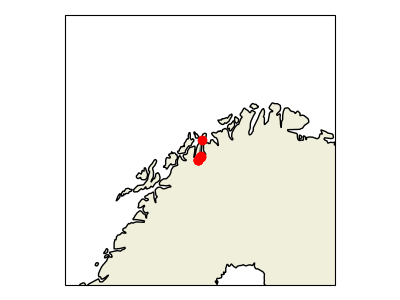

In [120]:
ctd.map(ds_ctd)

#### Look at some contours of the data

Use the interactive functionality to look through variables etc.

In [121]:
ctd.contour(ds_ctd)

#### Inspect individual profiles

In [122]:
ctd.inspect_profiles(ds_ctd)

There is a weird spike to low salinities in profile 8. That one should be corrected manually.

Now, let's make your own T-S diagram for water mass identification

For more fancy stuff, explore: https://xoa.readthedocs.io/en/develop/api/xoa.plot.plot_ts.html from https://xoa.readthedocs.io

In [127]:
fig, ax = plt.subplots()

# Plot all profiles on to p of each other
for nn in np.arange(ds_ctd.sizes['TIME']):
    x = ds_ctd['gsw_saA'].isel(TIME=nn, drop=True).squeeze()
    y = ds_ctd['gsw_ctA'].isel(TIME=nn, drop=True).squeeze()
    ax.plot(x, y, color='tab:blue', lw=0.5, alpha=1)

ax.set_xlabel('absolute salinity (kg/m3)')
ax.set_ylabel('conservative temperature ($^\circ$C)')

#improved version farther down

# Save as png
plt.savefig('../../../../plots/basic_TS_diagram.png') 

plt.close()

### Export to .netcdf and .mat format

Next we export the data to commonly used netcdf format. Note that we haven't really applied any post-processing steps, just joined the profiles and added some metadata. Since no quality control/ processing has been applied yet, we use a preliminary filename (unprocessed). Use the "Editing.ipynb" notebook to read the netcdf fiel and further process the data.  In case it is useful the dataset can also be exported for analysis in Matlab.

In [130]:
cruise_ctd_id = 'iC3-24-3-BP'
ds_ctd.attrs['id'] = cruise_ctd_id

nc_initial_dir = '../../../../netcdf'
ctd.to_netcdf(ds_ctd, nc_initial_dir, file_name = f'{cruise_ctd_id}_unprocessed')

#keeps bringing up error for me about being used by another process, unsure why

Updated history attribute. Current content:
---
2024-04-24 to 2024-09-13: Data collection.
2024-09-11 to 2024-09-13: Processed to .cnv using SBE software (details in "PROCESSING.SBE_processing").
2024-10-24: Post-processing.
2024-10-24: Creation of this netcdf file.
---


The file ..\..\..\..\netcdf\iC3-24-3-BP_unprocessed.nc already exists. Do you want to overwrite it? (y/n):  y


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: '..\\..\\..\\..\\netcdf\\iC3-24-3-BP_unprocessed.nc'

### Check the NetCDF
Load the nc file we just created and inspect it.

In [131]:
ds_load = ctd.from_netcdf('../../../../netcdf/' + f'{cruise_ctd_id}_unprocessed.nc')

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

In [132]:
mat_dir = '../../../../mat/'
ctd.to_mat(ds_ctd, mat_dir + 'ctd_data_unprocessed', simplify = True)

Dropped these variables from the Dataset: PROCESSING.
Saved the (simplified) Dataset to: ../../../../mat/ctd_data_unprocessed.mat


## Compute Bottle averages

Somewhere should also be a block of code to extract bottle averages

Probably, it also makes sense to fill in upper part of profile 10 with data from profile 9, as these are taken at the same location shortly after each other. -> filled up within data

##### Bottle averages for CTD
bottle depth +-2m


In [133]:
# Check logsheets for bottle depths

print(df_log)

     decimalLatitude  decimalLongitude  bottomDepthInMeters      locationID  \
0           70.00800         20.408300                353.0     72 (LYNG04)   
1           70.00800         20.408300                353.0     72 (LYNG04)   
2           70.00800         20.408300                353.0     72 (LYNG04)   
3           70.00800         20.408300                353.0     72 (LYNG04)   
4           70.00800         20.408300                353.0     72 (LYNG04)   
..               ...               ...                  ...             ...   
310         69.44625         20.256633                130.0  133 (LYNG-iC3)   
311         69.44625         20.256633                130.0  133 (LYNG-iC3)   
312         69.44625         20.256633                130.0  133 (LYNG-iC3)   
313         69.44625         20.256633                130.0  133 (LYNG-iC3)   
314         69.44625         20.256633                130.0  133 (LYNG-iC3)   

          gearType  niskinNumber  maximumDepthInMet

In [134]:
# Check CTD data to use for this processing and that STATION is used as a dimension

print(ds_ctd_calc)

<xarray.Dataset> Size: 252kB
Dimensions:      (STATION: 12, PRES: 323)
Coordinates:
  * STATION      (STATION) <U10 480B '60' '72' '74' '83' ... '127' '132' '133'
  * PRES         (PRES) float64 3kB 2.0 3.0 4.0 5.0 ... 322.0 323.0 324.0 325.0
    TIME         (STATION) float64 96B 1.984e+04 1.998e+04 ... 1.998e+04
    dim_0        (STATION) float64 96B nan 0.0 29.0 66.0 ... 242.0 nan 279.0
Data variables:
    TEMP1        (STATION, PRES) float64 31kB nan nan nan 5.123 ... nan nan nan
    CNDC1        (STATION, PRES) float64 31kB nan nan nan 3.106 ... nan nan nan
    flSP         (STATION, PRES) float64 31kB nan nan nan 0.4117 ... nan nan nan
    PSAL1        (STATION, PRES) float64 31kB nan nan nan nan ... nan nan nan
    gsw_saA0     (STATION, PRES) float64 31kB nan nan nan nan ... nan nan nan
    gsw_ctA0     (STATION, PRES) float64 31kB nan nan nan nan ... nan nan nan
    SBE_FLAG     (STATION, PRES) float64 31kB nan nan nan 0.0 ... nan nan nan
    TIME_SAMPLE  (STATION, PRES) float

In [136]:
# Calculate sensor averages (+- 2m) at Bottle depths

# Filter out rows where STATION is nan from logsheet to enable calculation with this value
df_log_filtered = df_log.dropna(subset=['STATION'])

# Initialize an empty list to store the results
bottles_CTD = []

# List of variables to calculate bottle averages for
variables_to_average = ds_ctd_calc.data_vars.keys()

# Extract values for STATION and bottle depths from logsheet for aligning them with CTD data
for _, row in df_log_filtered.iterrows():
    station_to_check = row['STATION']
    bottle_depths_meters = row['maximumDepthInMeters']

    # Filter the dataset for the specified station
    try:
        filtered = ds_ctd_calc.sel(STATION=station_to_check)
    except KeyError:
        print(f"STATION '{station_to_check}' not found in dataset.")
        continue

    # Create boolean condition for +-2 pressure window at bottle depths
    pressure_condition = (
        (filtered['PRES'] >= bottle_depths_meters - 2) &
        (filtered['PRES'] <= bottle_depths_meters + 2)
    )

    # Initialize a dictionary to store averages for each variable
    averages = {'STATION': station_to_check, 'maximumDepthInMeters': bottle_depths_meters}

    # Loop through each variable in the dataset
    for var in variables_to_average:
        # Check if the variable has the PRES dimension
        if 'PRES' in filtered[var].dims:
            # Apply the pressure condition to get valid values
            valid_values = filtered[var].where(pressure_condition, drop=True)

            # Calculate bottle average only if there are valid values
            if valid_values.size > 0:
                average_value = valid_values.mean().item()  # Convert to a scalar
                averages[var] = average_value
            else:
                averages[var] = None  # or np.nan, depending on your preference
        else:
            averages[var] = None  # Handle the case where the variable doesn't have PRES

    # Append the bottle averages dictionary to the results list
    bottles_CTD.append(averages)

# Convert the results list to a DataFrame
averages_CTD_df = pd.DataFrame(results)

# Remove duplicate rows
averages_CTD_df = averages_CTD_df.drop_duplicates()

# Save the resulting DataFrame to an Excel file
output_file_path = "Bottle_averages_CTD.xlsx"
averages_df.to_excel(output_file_path, index=False)

print(f"Averages DataFrame saved to '{output_file_path}'.")

Averages DataFrame saved to 'Bottle_averages_CTD.xlsx'.


In [142]:
# Plot profiles for certain variables at the different stations
#problem with adjusting x-axis range to be dynamic between varaibale and show all values within the plot well

# Load the CTD averages DataFrame
averages_df = pd.read_excel("Bottle_averages_CTD.xlsx")

# List of variables to plot
variables_to_plot = ['TEMP1', 'CNDC1', 'flSP', 'PSAL1', 'gsw_saA0', 'gsw_ctA0']

# Create a figure with subplots for each variable
num_vars = len(variables_to_plot)
fig, axs = plt.subplots(num_vars, 1, figsize=(10, 5 * num_vars), sharex=False)

# Create profiles for each variable
for i, var in enumerate(variables_to_plot):
    for station in averages_CTD_df['STATION'].unique():
        station_data_CTD = averages_CTD_df[averages_CTD_df['STATION'] == station]

        # Sort data by maximumDepthInMeters for proper plotting
        station_data_CTD = station_data_CTD.sort_values(by='maximumDepthInMeters')

        # Plot each station's data for the current variable
        if var in station_data_CTD.columns:
            # Connect the station values with lines and add dots
            axs[i].plot(station_data_CTD[var], station_data_CTD['maximumDepthInMeters'], 
                        marker='o', label=f'STATION {station}', linestyle='-')

    axs[i].invert_yaxis()  # Invert y-axis to have depth increasing downwards
    axs[i].set_title(f'Profile for {var}')
    axs[i].set_ylabel('Depth (m)')
    axs[i].grid()

    # Set fixed y-axis limits (depth)
    axs[i].set_ylim(130, 0)  
    
    # Set x-axis limits based on the current variable with a fixed ±1 buffer
    if var in station_data.columns:
        min_val = station_data[var].min()
        max_val = station_data[var].max()
        axs[i].set_xlim(min_val - 1, max_val + 1)  # Better ideas for buffer?

    axs[i].legend(title='Station', loc='best', fontsize='small')

plt.xlabel('Value')
plt.tight_layout()

# Save the plot
plt_file_path = '../../../../plots/profile_CTD_bottleav_{station}.png'
plt.savefig(plt_file_path)
plt.close()

##### Bottle averages for RBR
bottle depth +-2m


In [143]:
#basically same procedure as for CTD profiles, just slight variations due to differences in type of dataframe
#goal = bring both into similar format to be able to combine both

# Create an empty list to hold the results
average_list = []

# Extract values for STATION and bottle depths from logsheet for aligning them with RBR data
for index, row in df_log.iterrows():
    station_id = row['STATION']
    maximum_depth = row['maximumDepthInMeters']

    # Construct the profile name use only the the profiles from dragging sensor up, to exclude long stoptime influences
    profile_name = f"{station_id}_UP"

    # Check if the profile exists in binned_profiles
    if profile_name in binned_profiles:
        binned_df = binned_profiles[profile_name]

        # Convert Pressure_Binned to numeric if it's categorical
        if isinstance(binned_df['Pressure_Binned'].dtype, pd.CategoricalDtype):
            binned_df['Pressure_Binned'] = binned_df['Pressure_Binned'].cat.codes

        # Define the +-2 average pressure bounds for filtering
        lower_bound = maximum_depth - 2
        upper_bound = maximum_depth + 2

        # Filter the binned DataFrame for the relevant Pressure_Binned values
        filtered_data = binned_df[
            (binned_df['Pressure_Binned'] >= lower_bound) &
            (binned_df['Pressure_Binned'] <= upper_bound)
        ]

        # Calculate the mean of the other varaibles and add to the results list
        if not filtered_data.empty:
            # Create a dictionary to store RBR bottle averages, keeping STATION and bottle depth as identifiers
            averages_dict = {
                'STATION': station_id,
                'maximumDepthInMeters': maximum_depth,
            }
            averages_dict.update(filtered_data.mean(numeric_only=True).to_dict())
            average_list.append(averages_dict)

# Convert the list of dictionaries to a DataFrame
average_RBR = pd.DataFrame(average_list)

# Remove duplicates based on same results STATION and maximumDepthInMeters
average_RBR = average_RBR.drop_duplicates(subset=['STATION', 'maximumDepthInMeters'])

# Save the DataFrame
average_RBR.to_excel('Bottle_averages_RBR.xlsx', index=False)

In [144]:
# View created dataframe to get an impressions if binning went smoothly
print(average_RBR)

    STATION  maximumDepthInMeters  Pressure_Binned  Conductivity  Temperature  \
0        74                  54.0             54.0     38.285100    12.209171   
1        74                  40.0             40.0     38.404284    12.368411   
2        74                  20.0             20.0     38.440056    12.452312   
3        74                  10.0             10.0     38.346396    12.541034   
4        74                   2.0              2.0     38.173487    12.543119   
35       74                  25.0             25.0     38.428378    12.424687   
36       83                  50.0             50.0     38.311167    12.107267   
37       83                  20.0             20.0     38.449451    12.718980   
38       83                  10.0             10.0     38.418566    12.711901   
39       83                   2.0              2.0     38.427456    12.728406   
68       83                  25.0             25.0     38.457402    12.721403   
69       95                 

In [148]:
# Plot profiles for certain RBR variables at the different stations
#same problem with adjusting x-axis range to be dynamic between varaibale and show all values within the plot well

# Load the averages DataFrame
averages_rbr = pd.read_excel("Bottle_averages_RBR.xlsx")

# List of RBR variables to plot
variables_to_plot = ['Conductivity', 'Temperature', 'Pressure', 'Chlorophyll', 
                     'PAR', 'Sea pressure', 'Salinity', 'Density anomaly', 'Specific conductivity']

# Create a figure with subplots for each variable
num_vars = len(variables_to_plot)
fig, axs = plt.subplots(num_vars, 1, figsize=(12, 5 * num_vars), sharex=False)

# Define a color map for the different stations (to make t more fancy)
colors = plt.cm.viridis(np.linspace(0, 1, averages_rbr['STATION'].nunique()))

# Create profiles for each RBR variable
for i, var in enumerate(variables_to_plot):
    for j, station in enumerate(averages_rbr['STATION'].unique()):
        station_data = averages_rbr[averages_rbr['STATION'] == station]

        # Check if the variable is in the station data
        if var in station_data.columns:
            # Sort the data by maximumDepthInMeters
            station_data = station_data.sort_values(by='maximumDepthInMeters')

            # Plot each station's data for the current variable
            axs[i].plot(station_data[var], station_data['maximumDepthInMeters'], 
                         marker='o', label=f'STATION {station}', color=colors[j])

    axs[i].invert_yaxis()  # Invert y-axis (since ocean profile)
    axs[i].set_title(f'Profile for {var}', fontsize=14)
    axs[i].set_ylabel('Depth (meters)', fontsize=12)
    axs[i].grid(True, linestyle='--', alpha=0.7)

    # Set x-axis limits individually for each variable plot
    if not station_data.empty and var in station_data.columns:
        x_min = station_data[var].min() - 1  # What buffer would be good?
        x_max = station_data[var].max() + 1  
        axs[i].set_xlim(x_min, x_max) 

    axs[i].legend(title='Station', loc='best', fontsize='small', frameon=True, shadow=True)

# Set common xlabel
plt.xlabel('Value', fontsize=12)
plt.tight_layout()

# Save the plot
plt_file_path = '../../../../plots/profile_RBR_bottleav_{station}.png'
plt.savefig(plt_file_path)
plt.close()

## Mixed Layer Depth determination

In [149]:
# Calculation based on sigma0 (gsw library)

pressure = ds_ctd_calc['PRES'] 
temperature = ds_ctd_calc['TEMP1']  
salinity = ds_ctd_calc['PSAL1'] 

# Calculate potential density anomaly (sigma0)
sigma = gsw.density.sigma0(salinity, temperature)

# Calculate the surface potential density anomaly for each station
surface_sigma = sigma.isel(PRES=3)  # At 3m because of delayed CTD start since on boat

# Define the MLD threshold
density_threshold = surface_sigma + 0.125 

# Create a boolean mask for MLD
# Correctly broadcasting density_threshold
mld_mask = sigma > density_threshold.values[:, np.newaxis]  # Shape: (STATION, PRES)

# Calculate MLD: The first depth (pressure) where the density exceeds the threshold
mld_indices = mld_mask.argmax(dim='PRES')

# Convert MLD indices to actual depth values using pressure coordinate
mld_depth = xr.where(mld_indices > 0, pressure.isel(PRES=mld_indices), np.nan)

# Add MLD depth to the dataset as a new variable
ds_ctd_calc['mld'] = mld_depth
ds_ctd_calc['sigma0'] = sigma

# Display the MLD results
print(ds_ctd_calc['mld'])

<xarray.DataArray 'mld' (STATION: 12)> Size: 96B
array([nan, 26., 13., 33., 35., 28., 14.,  8., 19., 42., 29., 29.])
Coordinates:
  * STATION  (STATION) <U10 480B '60' '72' '74' '83' ... '118' '127' '132' '133'
    TIME     (STATION) float64 96B 1.984e+04 1.998e+04 ... 1.998e+04 1.998e+04
    dim_0    (STATION) float64 96B nan 0.0 29.0 66.0 ... 205.0 242.0 nan 279.0


In [150]:
# Which other calculation methods should be used?

In [152]:
#Visuald MLD determination based on plots, however same threshold used (could be adjusted)

# Define the threshold
threshold = 0.125

# Iterate through each station to create individual plots
for station in ds_ctd_calc['STATION'].values:
    # Select data for the current station
    station_sigma = sigma.sel(STATION=station)
    station_pressure = pressure  # Have Pressure remain the same for all stations
    station_surface_sigma = surface_sigma.sel(STATION=station)

    # Calculate the density threshold for the current station
    density_threshold = station_surface_sigma + threshold 

    # Find the indices where sigma exceeds the threshold
    mld_mask = station_sigma > density_threshold 
    threshold_index = mld_mask.argmax()  # Find the first index where the condition is true

    # Get the corresponding pressure value for the threshold
    if threshold_index > 0: 
        threshold_depth = station_pressure.isel(PRES=threshold_index).values
        visual_mld = density_threshold 
    else:
        threshold_depth = np.nan  # If the threshold is not exceeded
        visual_mld = np.nan

    # Print the value of the visual MLD
    print(f'Station {station}: Visual MLD = {visual_mld:.2f} kg/m³ at depth {threshold_depth:.2f} m')

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(station_sigma, -station_pressure, label='σ₀ (Potential Density)', color='blue')  # -pressure for depth
    if threshold_index > 0:  # Only plot if there's a valid threshold
        plt.axhline(y=-threshold_depth, color='red', linestyle='--', label=f'Sigma0 + {threshold} Exceeded')
    
    # Add labels and title
    plt.title(f'Potential Density Profile for Station {station}')
    plt.xlabel('Potential Density (σ₀) [kg/m³]')
    plt.ylabel('Depth (m)')
    plt.grid()
    plt.legend()
    
    # Save the plot
    plt_file_path = '../../../../plots/profile_MLD_{station}.png'
    plt.savefig(plt_file_path)
    plt.close()

Station 60: Visual MLD = nan kg/m³ at depth nan m
Station 72: Visual MLD = 24.71 kg/m³ at depth 26.00 m
Station 74: Visual MLD = 24.75 kg/m³ at depth 13.00 m
Station 83: Visual MLD = 24.75 kg/m³ at depth 33.00 m
Station 85: Visual MLD = 24.74 kg/m³ at depth 35.00 m
Station 95: Visual MLD = 24.92 kg/m³ at depth 28.00 m
Station 106: Visual MLD = 24.82 kg/m³ at depth 14.00 m
Station 113: Visual MLD = 24.62 kg/m³ at depth 8.00 m
Station 118: Visual MLD = 25.03 kg/m³ at depth 19.00 m
Station 127: Visual MLD = 25.06 kg/m³ at depth 42.00 m
Station 132: Visual MLD = 24.94 kg/m³ at depth 29.00 m
Station 133: Visual MLD = 24.94 kg/m³ at depth 29.00 m


In [154]:
# Create a fancy TS diagram

# Extract the necessary variables
temperature = ds_ctd_calc['TEMP1'].values  
salinity = ds_ctd_calc['PSAL1'].values  
pressure = ds_ctd_calc['PRES'].values 

# Calculate potential density (σ₀) from temperature and salinity (pressure assumed stable in this determination method)
sigma0 = gsw.sigma0(salinity, temperature)  

# Append sigma0 to ds_ctd_calc as a new variable
ds_ctd_calc['sigma0'] = (('STATION', 'PRES'), sigma0)  # Adjust dimensions as needed

# Calculate potential temperature (Theta)
# Assuming a standard reference pressure of 0 dbar for the theta calculation
p_ref = 0  # Reference pressure in dbar
theta = gsw.pt_from_t(salinity, temperature, pressure, p_ref)

# Create the T-S diagram
plt.figure(figsize=(10, 6))
scatter = plt.scatter(salinity, temperature, c=theta, cmap='viridis', edgecolor='k', s=50)
plt.colorbar(scatter, label='Potential Temperature (°C)')

# Add labels and title
plt.title('Temperature-Salinity Diagram')
plt.xlabel('Salinity (PSU)')
plt.ylabel('Temperature (°C)')

plt.grid(True)

# Save the plot
plt_file_path = '../../../../plots/fancy_TSdiagram.png'
plt.savefig(plt_file_path)
plt.close()

## Prepare Chl-a to calibarate with fluoresence later

In [186]:
# Two ways to add chlorophyll data to xarray dataset
# First: keep RBR pressure dimension

# Create a dictionary to hold the chlorophyll data to be added
chlorophyll_RBR_data = {}

# Iterate through each binned profile based on the station number
for profile_name, binned_df in binned_profiles.items():
    # Extract the STATION (ID) from the profile_name
    station_id = profile_name.split('_')[0]
    
    # Loop through the binned DataFrame to match with ds_ctd_calc
    for index, row in binned_df.iterrows():
        # Get the corresponding Pressure_Binned and Chlorophyll
        pressure_binned = row['Pressure_Binned']
        chlorophyll_value = row['Chlorophyll']

        # Create a key for the chlorophyll data based on the coordinates station and pressure
        key = (station_id, pressure_binned)

        # Add the chlorophyll value to the dictionary
        chlorophyll_data[key] = chlorophyll_value

# Convert the dictionary to a DataFrame with a multi-index (required for xarray 2D)
chlorophyll_RBR_df = pd.DataFrame.from_dict(chlorophyll_RBR_data, orient='index', columns=['Chlorophyll'])

# Set the index to be a multi-index (required for xarray 2D)
chlorophyll_RBR_df.index = pd.MultiIndex.from_tuples(chlorophyll_RBR_df.index, names=['STATION', 'Pressure_Binned'])

# Now we need to reshape the data into a 2D array for the DataArray
# Resetting the index to get STATION and Pressure_Binned back as columns
chlorophyll_RBR_df_reset = chlorophyll_RBR_df.reset_index()

# Pivot the DataFrame to create a matrix format for chlorophyll values
pivot_df = chlorophyll_RBR_df_reset.pivot(index='STATION', columns='Pressure_Binned', values='Chlorophyll')

# Convert the pivot DataFrame back to a DataArray
chlorophyll_RBR_xr = xr.DataArray(
    pivot_df.values,
    coords=[pivot_df.index, pivot_df.columns],
    dims=['STATION', 'Pressure_Binned']
)

# Append the chlorophyll data to ds_ctd_calc
ds_ctd_calc['Chlorophyll RBR dim'] = chlorophyll_RBR_xr

In [187]:
# Second method to add chlorophyll data to xarray dataset
# adjust from pressure binned length to PRES (different depths and stations for RBR profiles and CTD profiles)

# Get unique Pressure values from the PRES dimension of CTD xarray 
unique_pressures = ds_ctd_calc['PRES'].values

# Initialize chlorophyll array with NaNs for all STATION and PRES combinations
chlorophyll_values = np.full((len(ds_ctd_calc['STATION']), len(unique_pressures)), np.nan)

# Map the actaul existing Chlorophyll values from binned_profiles to chlorophyll_values array
for profile_name, df in binned_profiles.items():
    station_id = profile_name.split('_')[0]  # Extract station from profile_name of dataframe
    for index, row in df.iterrows():
        binned_pressure = row['Pressure_Binned']
        chlorophyll = row['Chlorophyll']
        
        # Find corresponding indices in the Chlorophyll array
        station_index = np.where(ds_ctd_calc['STATION'].values == station_id)[0]
        pressure_index = np.where(unique_pressures == binned_pressure)[0]
        
        # Check if indices are found
        if station_index.size > 0 and pressure_index.size > 0:
            chlorophyll_values[station_index[0], pressure_index[0]] = chlorophyll

# Create a new DataArray for Chlorophyll using the populated chlorophyll_values (same length as PRES)
chlorophyll_xr = xr.DataArray(
    chlorophyll_values,
    coords=[ds_ctd_calc['STATION'], unique_pressures],
    dims=['STATION', 'PRES']
)

# Assign the new Chlorophyll DataArray to ds_ctd_calc
ds_ctd_calc['Chlorophyll'] = chlorophyll_xr

# Save the modified ds_ctd_calc permanently
ds_ctd_calc.to_netcdf('ds_ctd_calc_with_chlorophyll.nc')

# Check to ensure Chlorophyll has been added
print(ds_ctd_calc['Chlorophyll'])

<xarray.DataArray 'Chlorophyll' (STATION: 12, PRES: 323)> Size: 31kB
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [1.89451476, 1.89164439, 1.85921935, ...,        nan,        nan,
               nan],
       ...,
       [0.51351629, 0.59054892, 0.58808956, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.66113202, 0.70919218, 0.77226081, ...,        nan,        nan,
               nan]])
Coordinates:
  * STATION  (STATION) <U10 480B '60' '72' '74' '83' ... '118' '127' '132' '133'
  * PRES     (PRES) float64 3kB 2.0 3.0 4.0 5.0 6.0 ... 322.0 323.0 324.0 325.0
    TIME     (STATION) float64 96B 1.984e+04 1.998e+04 ... 1.998e+04 1.998e+04
    dim_0    (STATION) float64 96B nan 0.0 29.0 66.0 ... 205.0 242.0 nan 279.0


## Plot Fjord transect and cross sections for certain varaiables

In [188]:
#Sort stations not by increasing numbers but my coordinates

#Latitude
# Create a DataFrame from the LATITUDE and STATION coordinates
latitudes = ds_ctd_calc['LATITUDE'].values
stations = ds_ctd_calc['STATION'].values

# Combine into a DataFrame for sorting by LATITUDE
lat_station_df = pd.DataFrame({
    'STATION': stations,
    'LATITUDE': latitudes
})

# Sort by LATITUDE
lat_station_df_sorted = lat_station_df.sort_values(by='LATITUDE')

# Extract the sorted STATION values
sorted_stations_lat = lat_station_df_sorted['STATION'].values.tolist()

# Ensure STATION 60 is first for LATITUDE sorting (if relevant for plotting)
if '60' in sorted_stations_lat:
    sorted_stations_lat = ['60'] + [station for station in sorted_stations_lat if station != '60']

# Update ds_ctd_calc to reorder the STATION coordinate and associated data by LATITUDE
ds_ctd_lat = ds_ctd_calc.sel(STATION=sorted_stations_lat, drop=True)  # Reindex and drop old coordinates
ds_ctd_lat = ds_ctd_lat_sorted.assign_coords(STATION=sorted_stations_lat)

# Display the new order of STATION sorted by LATITUDE
print("Sorted STATION coordinates by LATITUDE with STATION 60 first:")
print(ds_ctd_lat_sorted['STATION'].values)

#Longitude
# Create a DataFrame from the LONGITUDE and STATION coordinates
longitudes = ds_ctd_calc['LONGITUDE'].values

# Combine into a DataFrame for sorting by LONGITUDE
long_station_df = pd.DataFrame({
    'STATION': stations,
    'LONGITUDE': longitudes
})

# Sort by LONGITUDE
long_station_df_sorted = long_station_df.sort_values(by='LONGITUDE')

# Extract the sorted STATION values
sorted_stations_long = long_station_df_sorted['STATION'].values.tolist()

# Ensure STATION 60 is first for LONGITUDE sorting (in case relevant for plotting)
if '60' in sorted_stations_long:
    sorted_stations_long = ['60'] + [station for station in sorted_stations_long if station != '60']

# Update ds_ctd_calc to reorder the STATION coordinate and associated data by LONGITUDE
ds_ctd_long = ds_ctd_calc.sel(STATION=sorted_stations_long, drop=True)  # Reindex and drop old coordinates
ds_ctd_long = ds_ctd_long_sorted.assign_coords(STATION=sorted_stations_long)

# Display the new order of STATION sorted by LONGITUDE
print("Sorted STATION coordinates by LONGITUDE with STATION 60 first:")
print(ds_ctd_long_sorted['STATION'].values)

Sorted STATION coordinates by LATITUDE with STATION 60 first:
['60' '95' '106' '113' '74' '118' '127' '133' '83' '72' '85' '132']
Sorted STATION coordinates by LONGITUDE with STATION 60 first:
['60' '95' '106' '113' '74' '118' '127' '133' '83' '72' '85' '132']


In [189]:
# Use latitude to sort for fjord transect plot

# Convert station numbers to strings if necessary
Fjord_transect = [str(x) for x in [60, 72, 74, 83, 106, 127]] # 60 needed for plotting?

# Check available STATION values
print("Available STATION values in ds_ctd_lat:")
available_stations = ds_ctd_lat_sorted['STATION'].values
print(available_stations)

# Extract data for Fjord transect
try:
    ds_ctd_fjord = ds_ctd_lat_sorted.sel(STATION=Fjord_transect)
except KeyError as e:
    print(f"Error selecting Fjord transect: {e}")

# Print the resulting datasets if successfully created
if 'ds_ctd_fjord' in locals():
    print("\nFjord Transect Dataset:")
    print(ds_ctd_fjord)

Available STATION values in ds_ctd_lat:
['60' '95' '106' '113' '74' '118' '127' '133' '83' '72' '85' '132']

Fjord Transect Dataset:
<xarray.Dataset> Size: 159kB
Dimensions:          (PRES: 323, STATION: 6, Pressure_Binned: 107)
Coordinates:
  * PRES             (PRES) float64 3kB 2.0 3.0 4.0 5.0 ... 323.0 324.0 325.0
    TIME             (STATION) float64 48B 1.984e+04 1.998e+04 ... 1.998e+04
    dim_0            (STATION) float64 48B nan 0.0 29.0 66.0 137.0 242.0
  * Pressure_Binned  (Pressure_Binned) int64 856B 0 1 2 3 4 ... 103 104 105 106
  * STATION          (STATION) <U3 72B '60' '72' '74' '83' '106' '127'
Data variables: (12/15)
    TEMP1            (STATION, PRES) float64 16kB nan nan nan ... nan nan nan
    CNDC1            (STATION, PRES) float64 16kB nan nan nan ... nan nan nan
    flSP             (STATION, PRES) float64 16kB nan nan nan ... nan nan nan
    PSAL1            (STATION, PRES) float64 16kB nan nan nan ... nan nan nan
    gsw_saA0         (STATION, PRES) float6

In [190]:
# Use longitude to sort for cross section plots

# Convert station numbers to strings if necessary
River_cross = [str(x) for x in [60, 95, 106, 113]] #60 needed for plotting?
Glacier_cross = [str(x) for x in [60, 118, 127, 133]] #60 needed for plotting?

# Check available STATION values
print("Available STATION values in ds_ctd_long:")
available_stations = ds_ctd_long_sorted['STATION'].values
print(available_stations)

# Extract data for River cross
try:
    ds_ctd_river = ds_ctd_long_sorted.sel(STATION=River_cross)
except KeyError as e:
    print(f"Error selecting River cross: {e}")

# Extract data for Glacier cross
try:
    ds_ctd_glacier = ds_ctd_long_sorted.sel(STATION=Glacier_cross)
except KeyError as e:
    print(f"Error selecting Glacier cross: {e}")

if 'ds_ctd_river' in locals():
    print("\nRiver Cross Dataset:")
    print(ds_ctd_river)

if 'ds_ctd_glacier' in locals():
    print("\nGlacier Cross Dataset:")
    print(ds_ctd_glacier)

Available STATION values in ds_ctd_long:
['60' '95' '106' '113' '74' '118' '127' '133' '83' '72' '85' '132']

River Cross Dataset:
<xarray.Dataset> Size: 107kB
Dimensions:          (PRES: 323, STATION: 4, Pressure_Binned: 107)
Coordinates:
  * PRES             (PRES) float64 3kB 2.0 3.0 4.0 5.0 ... 323.0 324.0 325.0
    TIME             (STATION) float64 32B 1.984e+04 1.998e+04 ... 1.998e+04
    dim_0            (STATION) float64 32B nan 103.0 137.0 171.0
  * Pressure_Binned  (Pressure_Binned) int64 856B 0 1 2 3 4 ... 103 104 105 106
  * STATION          (STATION) <U3 48B '60' '95' '106' '113'
Data variables: (12/15)
    TEMP1            (STATION, PRES) float64 10kB nan nan nan ... nan nan nan
    CNDC1            (STATION, PRES) float64 10kB nan nan nan ... nan nan nan
    flSP             (STATION, PRES) float64 10kB nan nan nan ... nan nan nan
    PSAL1            (STATION, PRES) float64 10kB nan nan nan ... nan nan nan
    gsw_saA0         (STATION, PRES) float64 10kB nan nan nan .

In [191]:
# Different ways to plot profiles/transects based on Fjord transect

# Way 1
# Problem displayed colorfill seems to not align with station values, based on know depth (need 60 or not?)

# Define the list of variables to plot from ds_ctd_fjord
variables = ['TEMP1', 'PSAL1', 'flSP', 'sigma0', 'Chlorophyll']

# Get station and depth (PRES) coordinates
stations = ds_ctd_fjord['STATION'].values
depth = ds_ctd_fjord['PRES'].values 

# Loop over each variable and create individual transect plots
for var in variables:
    # Extract data for the current variable
    data = ds_ctd_fjord[var].values
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the filled contour for the variable (using pcolormesh for a simple example)
    c = ax.contourf(stations, depth, data.T, cmap='viridis', levels=100)  # Transpose data if needed
    plt.colorbar(c, ax=ax, label=f'{var} values')
    
    # Invert y-axis to show depth increasing downwards
    ax.invert_yaxis()
    
    # Label the axes
    ax.set_xlabel('Station')
    ax.set_ylabel('Depth (m)')
    ax.set_title(f'Transect of {var} along Stations')
    
    # Save the plot
    plt_file_path = '../../../../plots/fjord_transect_{var}.png'
    plt.savefig(plt_file_path)
    plt.close()

In [192]:
# transform transect and cross section, so they can be processed

ds_ctd_fjord = ds_ctd_fjord.swap_dims({'STATION':'TIME'})
ds_ctd_river = ds_ctd_river.swap_dims({'STATION':'TIME'})
ds_ctd_glacier = ds_ctd_glacier.swap_dims({'STATION':'TIME'})

In [193]:
# Alternative way to plot transect/cross sections
# However same problem as other transect with possible misalignment
# Include 60 or not?

ctd.contour(ds_ctd_fjord)

## Combine Bottle averages RBR and CTD to create station profiles

In [194]:
# Define the correct file paths for loading the Excel files
file_rbr = 'Bottle_averages_RBR.xlsx'
file_ctd = 'Bottle_averages_CTD.xlsx'

# Load the Excel files into DataFrames
rbr_df = pd.read_excel(file_rbr)
ctd_df = pd.read_excel(file_ctd)

# Ensure that both 'STATION' and 'maximumDepthInMeters' columns have the same data type in both dataframes
rbr_df['STATION'] = rbr_df['STATION'].astype(int)
ctd_df['STATION'] = ctd_df['STATION'].astype(int)

rbr_df['maximumDepthInMeters'] = rbr_df['maximumDepthInMeters'].astype(float)
ctd_df['maximumDepthInMeters'] = ctd_df['maximumDepthInMeters'].astype(float)

# Merge the two dataframes on 'STATION' and 'maximumDepthInMeters' using an outer join
combined_df = pd.merge(ctd_df, rbr_df, how='outer', on=['STATION', 'maximumDepthInMeters'])

# Save the combined dataframe to a new Excel file
combined_df.to_excel('Bottle_averages_combined.xlsx', index=False)

In [195]:
# Add sigma0 to combined dataframe

# Load the combined Excel file
combined_df = pd.read_excel('Bottle_averages_combined.xlsx')

# calculate sigma only for valid rows
valid_rows = combined_df['TEMP1'].notna() & combined_df['PSAL1'].notna()

# Extract 'SA' (absolute salinity) and 'CT' (conservative temperature) from valid rows
SA = combined_df.loc[valid_rows, 'PSAL1'].values
CT = combined_df.loc[valid_rows, 'TEMP1'].values

# Calculate sigma-0 using gsw library
sigma0 = gsw.sigma0(SA, CT)

# Assign the calculated sigma-0 values to the corresponding rows in the original dataframe
combined_df.loc[valid_rows, 'sigma_0'] = sigma0

# Save the updated dataframe back to the Excel file
combined_df.to_excel('Bottle_averages_combined_with_sigma0.xlsx', index=False)

# Return the path to the updated Excel file
'Bottle_averages_combined_with_sigma0.xlsx'

'Bottle_averages_combined_with_sigma0.xlsx'

In [198]:
# Plot profiles for certain variables at the different stations

combined_df = pd.read_excel('Bottle_averages_combined_with_sigma0.xlsx')

# List of variables to plot
variables = {
    'TEMP1': 'Temperature (°C)',
    'PSAL1': 'Salinity (PSU)',
    'sigma_0': 'Sigma-0 (kg/m³)',
    'Chlorophyll': 'Chlorophyll (mg/m³)',
    'PAR': 'PAR (μmol/m²/s)'
}

# Get unique stations
stations = combined_df['STATION'].unique()

# Plotting for each station
for station in stations:
    # Filter data for the current station
    station_df = combined_df[combined_df['STATION'] == station]

    # Create a figure and set of subplots
    fig, axs = plt.subplots(1, len(variables), figsize=(20, 8), sharey=True)
    
    # Set plot title for the current station
    fig.suptitle(f'Profile for Station {station}', fontsize=16)

    # Loop through variables and create subplots
    for i, (var, label) in enumerate(variables.items()):
        axs[i].plot(station_df[var], station_df['maximumDepthInMeters'], marker='o', linestyle='-', markersize=5)
        axs[i].invert_yaxis()  # Invert y-axis so depth increases downwards
        axs[i].set_xlabel(label)
        axs[i].set_ylabel('Depth (m)' if i == 0 else '')
        axs[i].grid(True)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
   # Save the plot
    plt_file_path = '../../../../plots/profiles_{station}.png'
    plt.savefig(plt_file_path)
    plt.close()

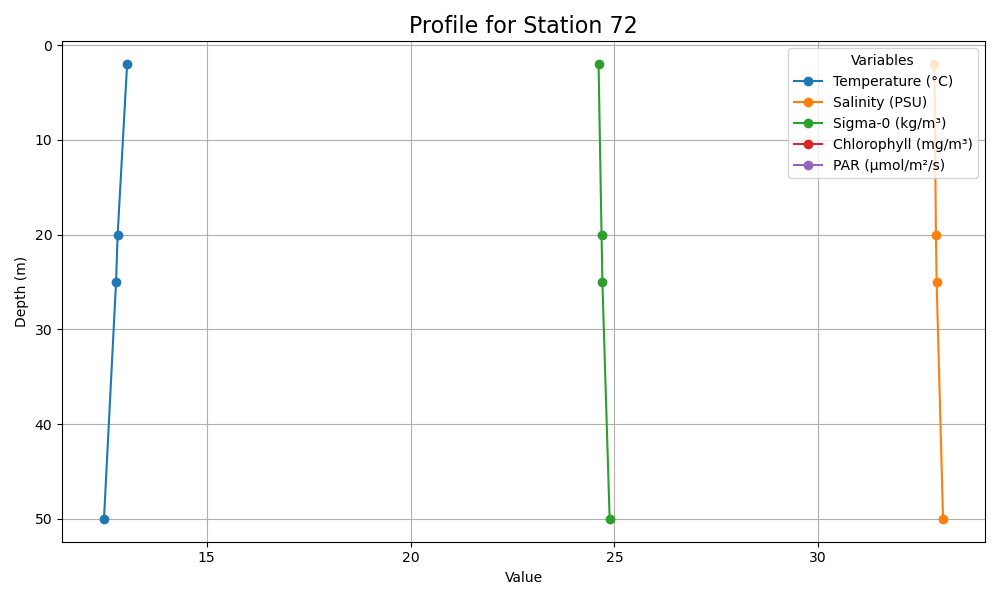

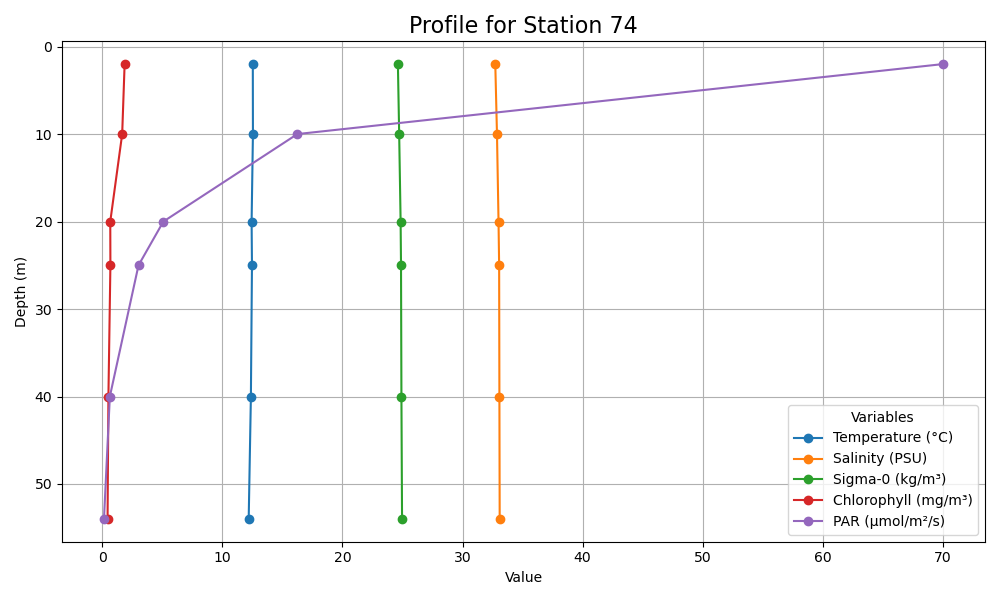

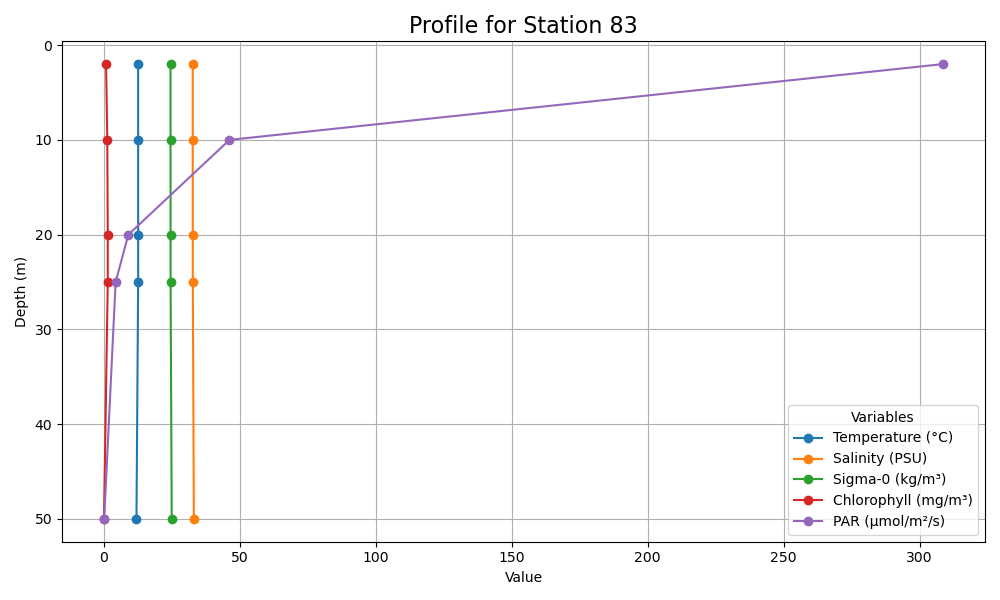

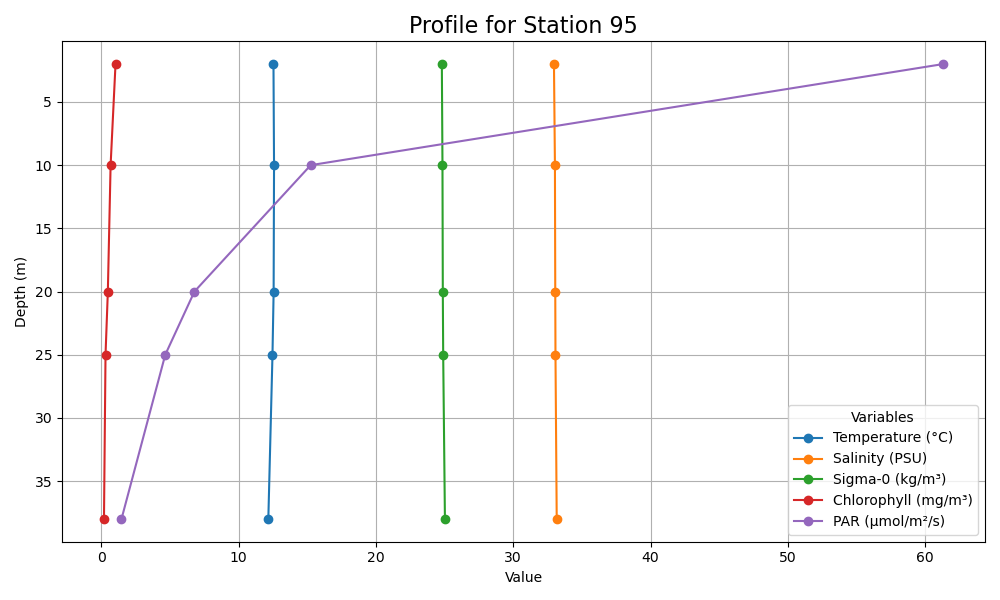

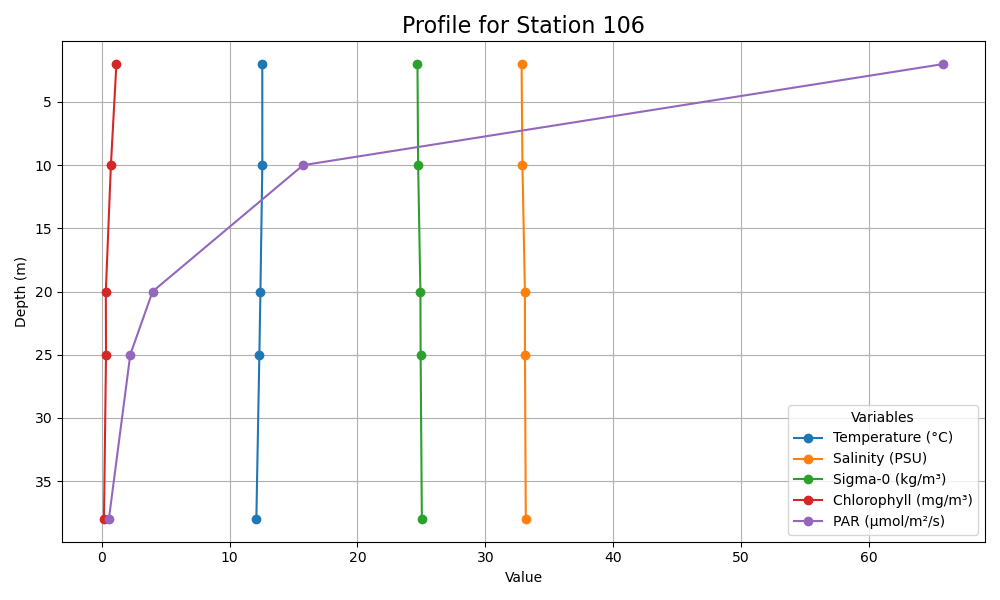

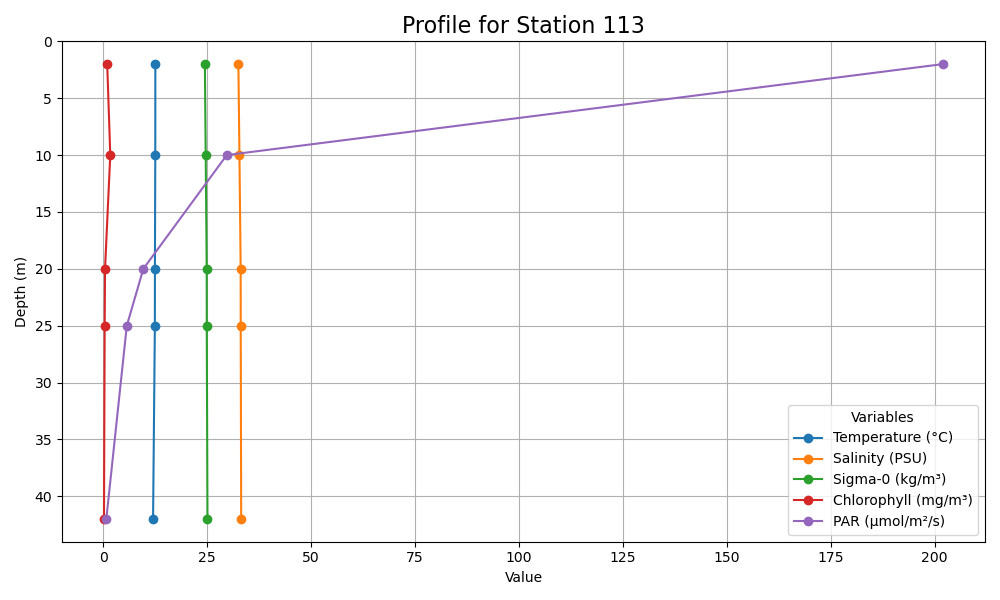

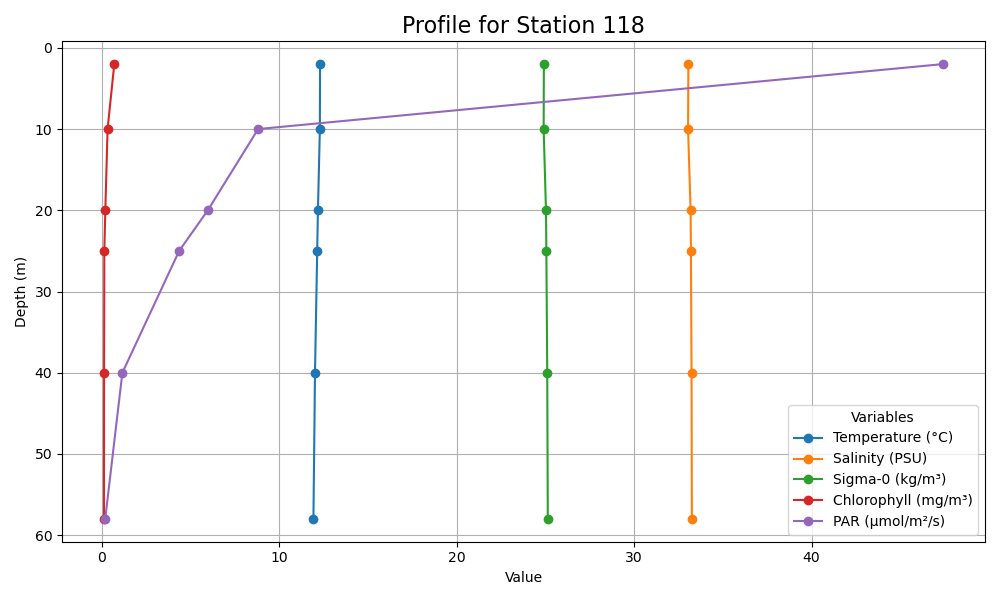

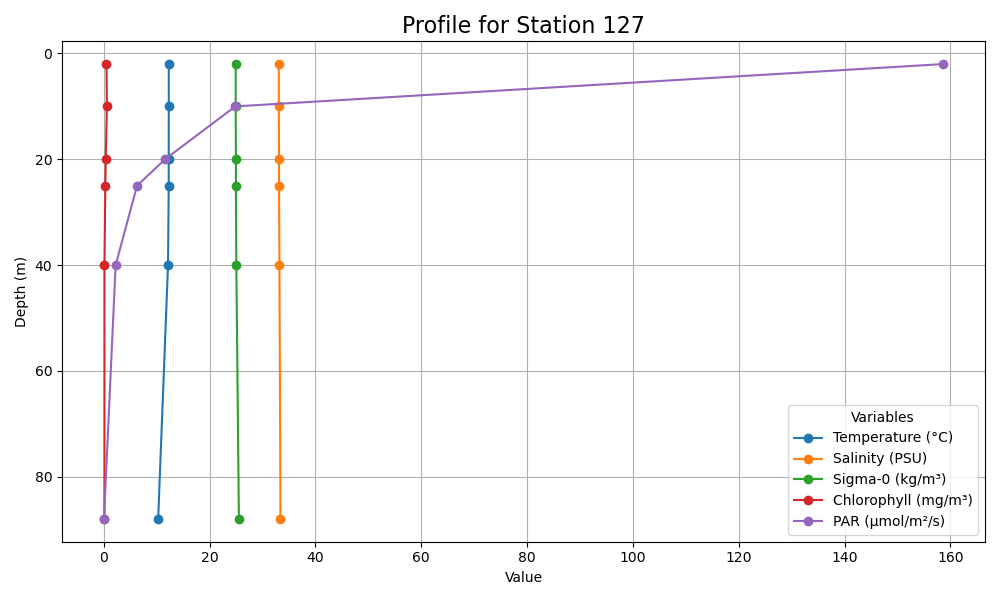

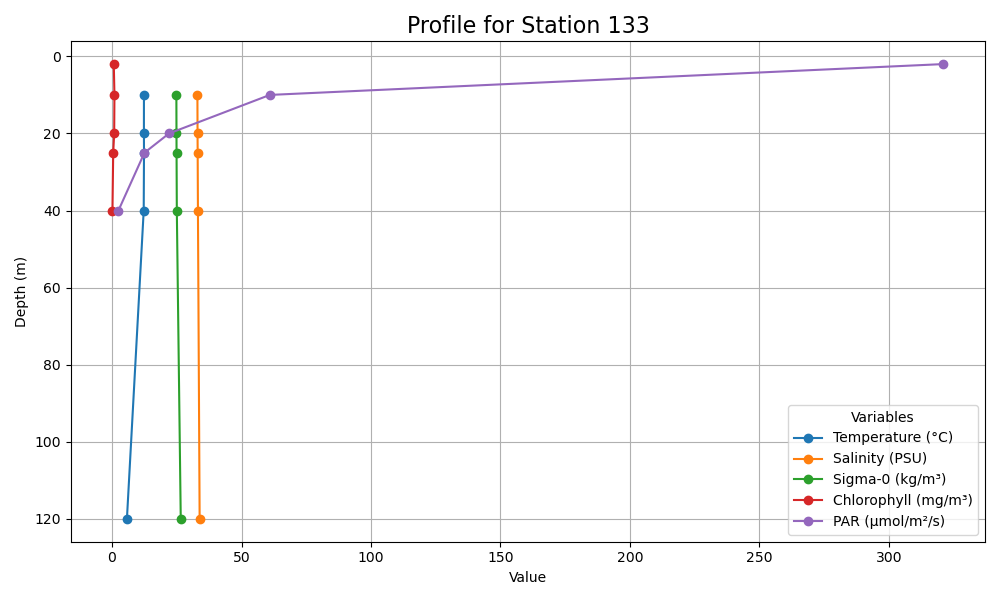

In [199]:
# Alternative:
# Plot profiles for varaiables aat different stations
# However scale is of and cannot be made logarithmic due to negative values, know a fix?

combined_df = pd.read_excel('Bottle_averages_combined_with_sigma0.xlsx')

# List of variables to plot
variables = {
    'TEMP1': 'Temperature (°C)',
    'PSAL1': 'Salinity (PSU)',
    'sigma_0': 'Sigma-0 (kg/m³)',
    'Chlorophyll': 'Chlorophyll (mg/m³)',
    'PAR': 'PAR (μmol/m²/s)'
}

# Get unique stations
stations = combined_df['STATION'].unique()

# Plotting for each station
for station in stations:
    # Filter data for the current station
    station_df = combined_df[combined_df['STATION'] == station]

    # Create a figure for the current station
    plt.figure(figsize=(10, 6))

    # Set plot title for the current station
    plt.title(f'Profile for Station {station}', fontsize=16)

    # Loop through variables and plot them on the same axes
    for var, label in variables.items():
        plt.plot(station_df[var], station_df['maximumDepthInMeters'], marker='o', linestyle='-', label=label)

    plt.gca().invert_yaxis()  # Invert y-axis so depth increases downwards
    plt.xlabel('Value')
    plt.ylabel('Depth (m)')
    plt.legend(title='Variables')
    plt.grid(True)

    # Show plot for the current station
    plt.tight_layout()
    plt.show()

## Chl-a sensor calibration

First, the median value of dark counts at depth was determined based on measurements from 100 to 500 m depth. A visual inspection confirmed that there were no offsets between profiles. To calibrate the bottle Chl-a data to the bottle fluorescence measurements, we first only considered the bottle Chl-a value when the standard deviation of the bottle value divided by the fluorescence measurement was < 0.15, to avoid highly noisy parts of the fluorescence profile. Then we subtracted the offset value (1.0495) from the bottle fluorescence measurement, then we fit a linear regression with the bottle Chl-a measurement.

In [201]:
# Check cholorphyll was added to xarray and which chlorophyll to use 

print(ds_ctd_calc)

<xarray.Dataset> Size: 283kB
Dimensions:              (STATION: 12, PRES: 323, Pressure_Binned: 0)
Coordinates:
  * STATION              (STATION) <U10 480B '60' '72' '74' ... '132' '133'
  * PRES                 (PRES) float64 3kB 2.0 3.0 4.0 ... 323.0 324.0 325.0
    TIME                 (STATION) float64 96B 1.984e+04 1.998e+04 ... 1.998e+04
    dim_0                (STATION) float64 96B nan 0.0 29.0 ... 242.0 nan 279.0
  * Pressure_Binned      (Pressure_Binned) object 0B 
Data variables: (12/14)
    TEMP1                (STATION, PRES) float64 31kB nan nan nan ... nan nan
    CNDC1                (STATION, PRES) float64 31kB nan nan nan ... nan nan
    flSP                 (STATION, PRES) float64 31kB nan nan nan ... nan nan
    PSAL1                (STATION, PRES) float64 31kB nan nan nan ... nan nan
    gsw_saA0             (STATION, PRES) float64 31kB nan nan nan ... nan nan
    gsw_ctA0             (STATION, PRES) float64 31kB nan nan nan ... nan nan
    ...                   .

In [203]:
# Median value of dark counts at depth was determined based on measurements from 100 to 500 m depth
# for visual inspect see profile check earlier

# Filter for PRES > 100
filtered_flSP = ds_ctd_calc['flSP'].where(ds_ctd_calc['PRES'] > 100, drop=True)

# Calculate the median value
median_flSP = filtered_flSP.median()

# Print the median value
print("Median value of flSP for PRES > 100 m:", median_flSP.values)

Median value of flSP for PRES > 100 m: 0.039092


In [204]:
# Determine standard deviation for RBR

# Create an empty list to hold the standard deviation results
std_dev_list = []

# Based on calcualting standard dev for bottle averages
# Same principle as calculating bottle averages at first 

for index, row in df_log.iterrows():
    station_id = row['STATION']
    maximum_depth = row['maximumDepthInMeters']

    # Construct the profile name
    profile_name = f"{station_id}_UP"

    # Check if the profile exists in binned_profiles
    if profile_name in binned_profiles:
        binned_df = binned_profiles[profile_name]

        # Convert Pressure_Binned to numeric if it's categorical
        if isinstance(binned_df['Pressure_Binned'].dtype, pd.CategoricalDtype):
            binned_df['Pressure_Binned'] = binned_df['Pressure_Binned'].cat.codes

        # Define the +-2m pressure bounds for bottle averages
        lower_bound = maximum_depth - 2
        upper_bound = maximum_depth + 2

        # Filter the binned DataFrame for the relevant Pressure_Binned values
        filtered_data = binned_df[
            (binned_df['Pressure_Binned'] >= lower_bound) &
            (binned_df['Pressure_Binned'] <= upper_bound)
        ]

        # Calculate the standard deviation of the relevant columns and add to the results list
        if not filtered_data.empty:
            # Create a dictionary to store standard deviations
            std_dev_dict = {
                'STATION': station_id,
                'maximumDepthInMeters': maximum_depth,
            }

            # Calculate standard deviations for numeric columns
            std_dev_values = filtered_data.std(numeric_only=True).to_dict()
            
            # Add standard deviation values to the dictionary
            std_dev_dict.update({f'std_{key}': value for key, value in std_dev_values.items()})

            # Append the results
            std_dev_list.append(std_dev_dict)

# Convert the list of dictionaries to a DataFrame
std_dev_RBR = pd.DataFrame(std_dev_list)

# Remove duplicates based on relevant columns (e.g., STATION and maximumDepthInMeters)
std_dev_RBR = std_dev_RBR.drop_duplicates(subset=['STATION', 'maximumDepthInMeters'])

# Save the DataFrame
std_dev_RBR.to_excel('Bottle_std_dev_RBR.xlsx', index=False)

In [207]:
# Extract deviations and add them onto combined dataframe of RBR and CTD bottle averages

# Load the combined DataFrame
combined_df = pd.read_excel('Bottle_averages_combined_with_sigma0.xlsx')

# Convert the STATION columns to string type for consistent merging
combined_df['STATION'] = combined_df['STATION'].astype(str)
std_dev_RBR['STATION'] = std_dev_RBR['STATION'].astype(str)

# Merge combined_df with std_dev_RBr on STATION and maximumDepthInMeters
combined_df = combined_df.merge(std_dev_RBR, on=['STATION', 'maximumDepthInMeters'], how='left')

# Save the updated combined DataFrame back to the Excel file
combined_df.to_excel('Bottle_averages_combined_with_sigma0_std.xlsx', index=False)

# Display the first few rows of the updated combined DataFrame for verification
print(combined_df.head())

  STATION  maximumDepthInMeters      TEMP1     CNDC1      flSP      PSAL1  \
0      72                   2.0  13.046133  3.874405  0.189190  32.848667   
1      72                  20.0  12.813660  3.857658  0.109760  32.885140   
2      72                  25.0  12.774680  3.856145  0.089006  32.902660   
3      72                  50.0  12.478560  3.846519  0.058329  33.059900   
4      72                 343.0        NaN       NaN       NaN        NaN   

    gsw_saA0  gsw_ctA0  SBE_FLAG   TIME_SAMPLE  ...  std_Temperature  \
0  33.004867  13.08310       0.0  19975.666190  ...              NaN   
1  33.041500  12.84690       0.0  19975.666574  ...              NaN   
2  33.059120  12.80678       0.0  19975.666648  ...              NaN   
3  33.217280  12.50322       0.0  19975.667158  ...              NaN   
4        NaN       NaN       NaN           NaN  ...              NaN   

   std_Pressure  std_Chlorophyll  std_PAR  std_Sea pressure  std_Depth  \
0           NaN              N

In [208]:
# Determine if bottle Chl-a value when the standard deviation of the bottle value divided by the fluorescence measurement was < 0.15, to avoid highly noisy parts of the fluorescence profile

# Ensure the columns 'std_Chlorophyll' and 'flSP' exist in combined_df
if 'std_Chlorophyll' in combined_df.columns and 'flSP' in combined_df.columns:
    # Calculate the ratio
    ratio = combined_df['std_Chlorophyll'] / combined_df['flSP']

    # Create a new column to store the ratio (optional)
    combined_df['Chlorophyll_Ratio'] = ratio

    # Filter the DataFrame where the ratio is smaller than 0.15
    filtered_df = combined_df[ratio < 0.15]

    # Display the filtered DataFrame
    print(filtered_df)
    
    # Create a new DataFrame by excluding the rows where the ratio is smaller than 0.15
    df_chlaB = combined_df[ratio >= 0.15].copy()  # Copy to create a new DataFrame

    # Remove the ratio column
    df_chlaB['Chlorophyll_Ratio'] = ratio[ratio >= 0.15]

   STATION  maximumDepthInMeters     TEMP1     CNDC1      flSP     PSAL1  \
21      95                  38.0  12.15875  3.827293  0.051337  33.16280   
24     106                  20.0  12.41012  3.842318  0.068759  33.09234   
33     118                  10.0  12.29034  3.825227  0.084719  33.03794   
37     118                  58.0  11.92762  3.816304  0.045985  33.25350   
42     127                  40.0  12.14264  3.829644  0.049255  33.19874   
45     133                  10.0  12.31374  3.819926  0.152096  32.96634   

     gsw_saA0   gsw_ctA0  SBE_FLAG   TIME_SAMPLE  ...  std_Pressure  \
21  33.320575  12.182175       0.0  19978.339537  ...      1.101841   
24  33.249700  12.437860       0.0  19978.428619  ...      1.612468   
33  33.195040  12.320240       0.0  19979.316474  ...      1.651348   
37  33.411800  11.946080       0.0  19979.320203  ...      1.232994   
42  33.356700  12.164940       0.0  19979.430479  ...      1.584911   
45  33.123060  12.345240       0.0  19979

In [209]:
# Check flouresence values
print(df_chlaB['flSP'])

5     0.271927
6     0.241428
7     0.143950
8     0.095974
9     0.077842
10    0.074950
11    0.151233
12    0.208936
13    0.198614
14    0.192490
15    0.050057
17    0.156640
18    0.120390
19    0.093179
20    0.077872
22    0.182120
23    0.169956
25    0.068517
26    0.052975
27    0.215665
28    0.223778
29    0.086915
30    0.076112
31    0.048992
32    0.088325
34    0.063380
35    0.058341
36    0.047034
38    0.074699
39    0.089011
40    0.073327
41    0.071277
43    0.044979
46    0.133608
47    0.106562
48    0.050362
Name: flSP, dtype: float64


In [211]:
# Then we subtracted the offset value (1.0495) from the bottle fluorescence measurement

# Subtract 1.0495 from all values in the flSP column
df_chlaB['flSP'] = df_chlaB['flSP'] - 1.0495

# Check flouresence values again
print(df_chlaB['flSP'])

5    -1.827073
6    -1.857572
7    -1.955050
8    -2.003026
9    -2.021158
10   -2.024050
11   -1.947767
12   -1.890064
13   -1.900386
14   -1.906510
15   -2.048943
17   -1.942360
18   -1.978610
19   -2.005821
20   -2.021128
22   -1.916880
23   -1.929044
25   -2.030483
26   -2.046025
27   -1.883335
28   -1.875222
29   -2.012085
30   -2.022888
31   -2.050008
32   -2.010675
34   -2.035620
35   -2.040659
36   -2.051966
38   -2.024301
39   -2.009989
40   -2.025673
41   -2.027723
43   -2.054021
46   -1.965392
47   -1.992438
48   -2.048638
Name: flSP, dtype: float64


In [212]:
# then we fit a linear regression with the bottle Chl-a measurement
# Two alterantives
# First = just calculating

# Drop rows with NaN values in 'flSP' or 'Chlorophyll'
df_chlaB = df_chlaB.dropna(subset=['flSP', 'Chlorophyll'])

# Prepare the variables
X = df_chlaB['flSP'].values
y = df_chlaB['Chlorophyll'].values

# Perform linear regression using numpy
A = np.vstack([X, np.ones(len(X))]).T  # Create a design matrix
m, b = np.linalg.lstsq(A, y, rcond=None)[0]  # Least squares solution

# Output the coefficients
print(f"Slope: {m}, Intercept: {b}")

Slope: 7.490717741459656, Intercept: 15.526956476737437


In [214]:
# Second = plot creation

# Prepare the data
X = df_chlaB[['flSP']]  # Predictor variable (flSP)
y = df_chlaB['Chlorophyll']  # Response variable (Chlorophyll)

# Create a Linear Regression model
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Get the coefficients
slope = model.coef_[0]
intercept = model.intercept_
print(f"Slope: {slope}, Intercept: {intercept}")

# Make predictions
y_pred = model.predict(X)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df_chlaB['flSP'], df_chlaB['Chlorophyll'], color='green', label='Data Points')
plt.plot(df_chlaB['flSP'], y_pred, color='lime', linewidth=2, label='Linear Regression Line')
plt.title('Linear Regression: flSP vs Chlorophyll')
plt.xlabel('flSP')
plt.ylabel('Chlorophyll')
plt.legend()
plt.grid()
plt_file_path = '../../../../plots/chla_flSP_regression.png'
plt.savefig(plt_file_path)
plt.close()


Slope: 7.4907177414596315, Intercept: 15.526956476737379
